## Loading all packages

In [1]:
# Reload all modules
%load_ext autoreload
%autoreload 2

# Other package imports
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# User packages.
from features.FitnessAnalysis import MultipleFitnessAnalysis
from features.RandomWalkAnalysis import MultipleRandomWalkAnalysis
from features.LandscapeAnalysis import LandscapeAnalysis

from cases.MW_setup import MW3, MW7
import numpy as np
from optimisation.model.population import Population
from sampling.RandomWalk import RandomWalk
import pickle

## Evaluating populations

In [2]:
problem = MW7(n_dim=5)  # use default dimensionality.
n_variables = problem.dim

# Experimental setup of Alsouly
neighbourhood_size = 2 * n_variables + 1
num_steps = int(n_variables / neighbourhood_size * 10**3)
step_size = 0.2  # 2% of the range of the instance domain

# Bounds of the decision variables.
x_lower = problem.lb
x_upper = problem.ub
bounds = np.vstack((x_lower, x_upper))

num_samples = 30

# Run feature eval multiple times.
pops = []
rw = RandomWalk(bounds, num_steps, step_size)
for ctr in range(num_samples):
    # Simulate RW
    walk = rw._do(seed=ctr)

    # Generate neighbours.
    new_walk = rw.generate_neighbours_for_walk(walk, neighbourhood_size)

    pop = Population(problem, n_individuals=num_steps)
    pop.evaluate(walk)
    print(
        "Evaluated rank and crowding for RW population {} of {}".format(
            ctr + 1, num_samples
        )
    )
    pops.append(pop)

# Saving results to pickle file.
with open("data/{}_d2_pop_data.pkl".format(problem.problem_name), "wb") as outp:
    pickle.dump(pops, outp, -1)

Evaluated rank and crowding for RW population 1 of 30
Evaluated rank and crowding for RW population 2 of 30
Evaluated rank and crowding for RW population 3 of 30
Evaluated rank and crowding for RW population 4 of 30
Evaluated rank and crowding for RW population 5 of 30
Evaluated rank and crowding for RW population 6 of 30
Evaluated rank and crowding for RW population 7 of 30
Evaluated rank and crowding for RW population 8 of 30
Evaluated rank and crowding for RW population 9 of 30
Evaluated rank and crowding for RW population 10 of 30
Evaluated rank and crowding for RW population 11 of 30
Evaluated rank and crowding for RW population 12 of 30
Evaluated rank and crowding for RW population 13 of 30
Evaluated rank and crowding for RW population 14 of 30
Evaluated rank and crowding for RW population 15 of 30
Evaluated rank and crowding for RW population 16 of 30
Evaluated rank and crowding for RW population 17 of 30
Evaluated rank and crowding for RW population 18 of 30
Evaluated rank and 

## Evaluating features over all populations

In [3]:
# Reload all modules
%load_ext autoreload
%autoreload 2

# Loading results from pickle file.
with open("data/MW7_d2_pop_data.pkl", "rb") as inp:
    pops = pickle.load(inp)


# Global features.
global_features = MultipleFitnessAnalysis(pops)
global_features.eval_features_for_all_populations()

# Random walk features.
rw_features = MultipleRandomWalkAnalysis(pops)
rw_features.eval_features_for_all_populations()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Evaluated MultipleFitnessAnalysis features for population 1 of 30
Evaluated MultipleFitnessAnalysis features for population 2 of 30
Evaluated MultipleFitnessAnalysis features for population 3 of 30
Evaluated MultipleFitnessAnalysis features for population 4 of 30
Evaluated MultipleFitnessAnalysis features for population 5 of 30
Evaluated MultipleFitnessAnalysis features for population 6 of 30
Evaluated MultipleFitnessAnalysis features for population 7 of 30
Evaluated MultipleFitnessAnalysis features for population 8 of 30
Evaluated MultipleFitnessAnalysis features for population 9 of 30
Evaluated MultipleFitnessAnalysis features for population 10 of 30
Evaluated MultipleFitnessAnalysis features for population 11 of 30
Evaluated MultipleFitnessAnalysis features for population 12 of 30
Evaluated MultipleFitnessAnalysis features for population 13 of 30
Evaluated MultipleFitnessAnalysis features for pop

## Plotting decision variables, objectives

/Users/richardrutherford/anaconda3/envs/thesis_env_py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


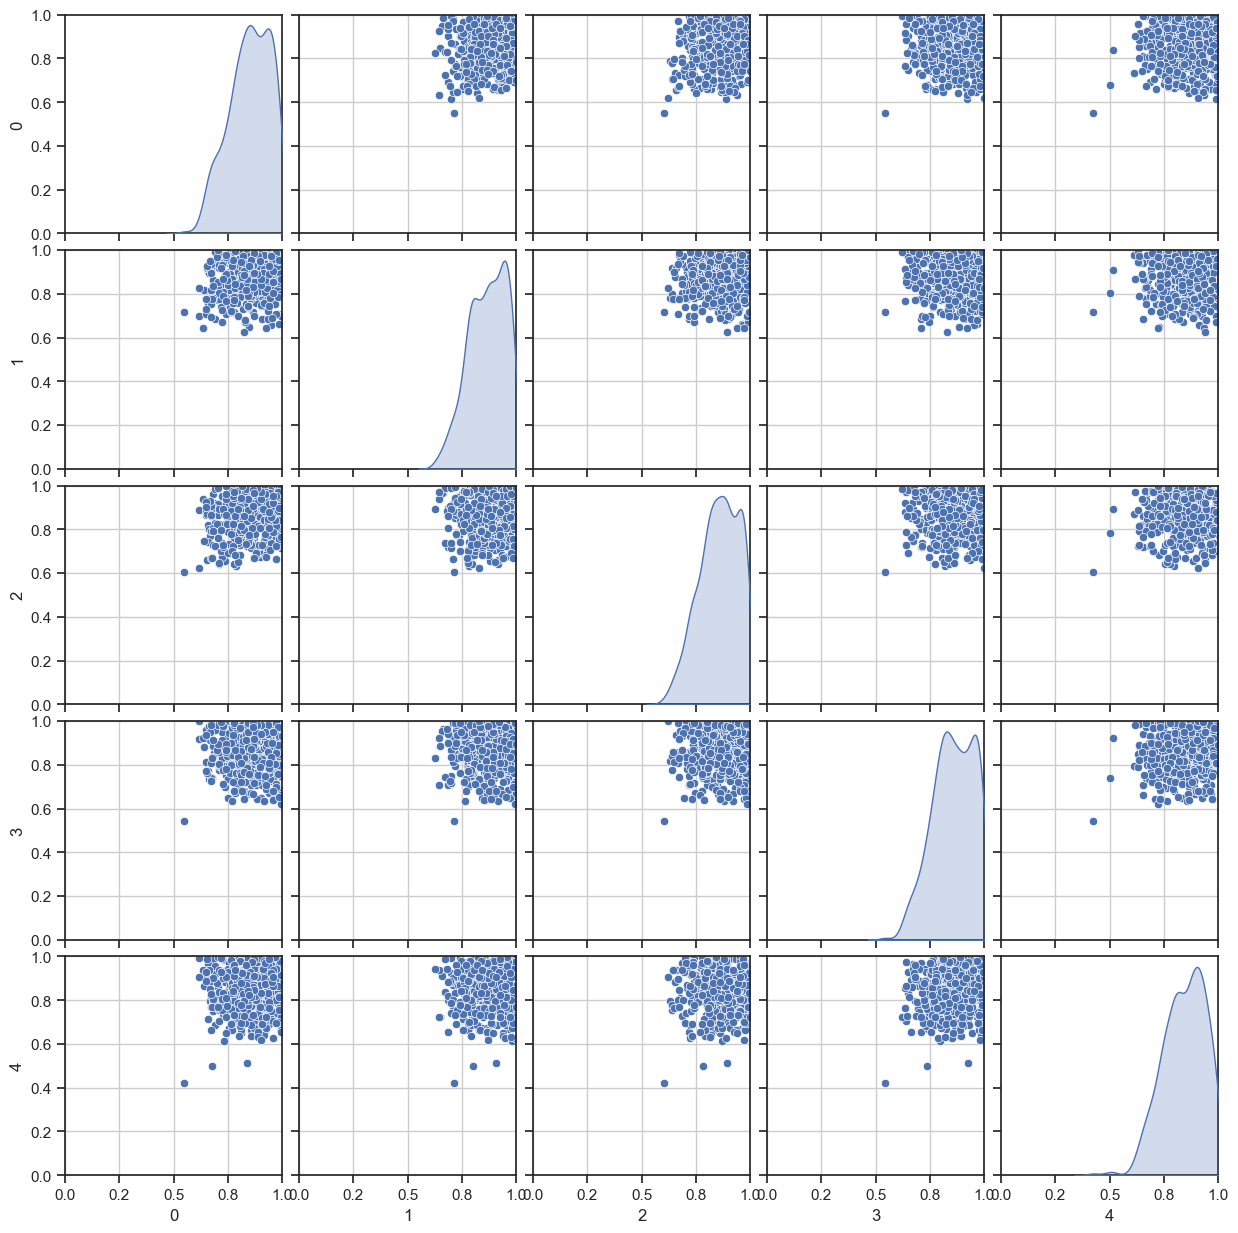

In [4]:
# # Plot objectives
# # Create a 5x6 grid of subplots
# fig, ax = plt.subplots(5, 6, figsize=(10, 10))
# for i in range(5):
#     for j in range(6):
#         pop = pops[i + j]

#         obj = pop.extract_obj()

#         # Plot the objectives on the current subplot.
#         ax[i, j].scatter(obj[:, 0], obj[:, 1], s=2, color="red")

# # Adjust subplot spacing
# plt.tight_layout()

# # Show the plot
# plt.show()

# # Plot decisions
# # Create a 5x6 grid of subplots
# fig, ax = plt.subplots(5, 6, figsize=(10, 10))
# for i in range(5):
#     for j in range(6):
#         pop = pops[i + j]

#         var = pop.extract_var()

#         # Plot the varision vars on the current subplot.
#         ax[i, j].scatter(var[:, 0], var[:, 1], s=2, color="green")

# # Adjust subplot spacing
# plt.tight_layout()

# # Show the plot
# plt.show()

# Plot the pairwise combinations of decision variables.
pops[0].var_scatterplot_matrix()

## Aggregating features

In [5]:
# Combine all features.
landscape = LandscapeAnalysis(global_features, rw_features)
landscape.extract_feature_arrays()
landscape.aggregate_features(YJ_transform=False)
landscape.extract_features_vector()
landscape.map_features_to_instance_space()

## Feature distributions

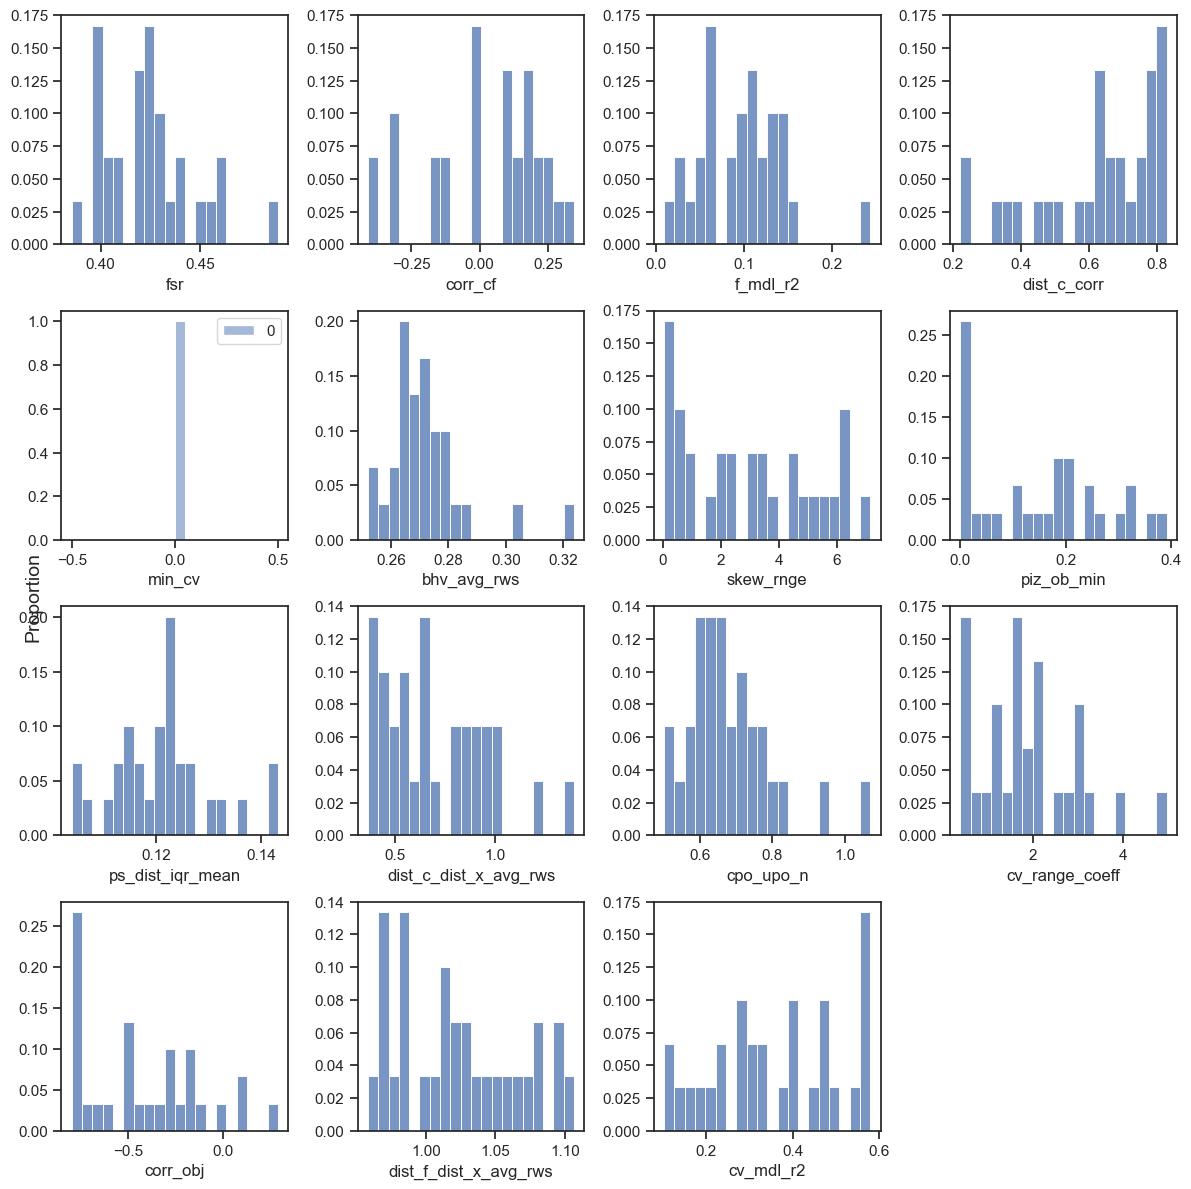

In [6]:
%autoreload 2
landscape.plot_feature_histograms()
landscape.plot_feature_violin_box_plots()

## Comparison to Alsouly's results

In [7]:
# Saving results to pickle file.
with open("data/MW3_landscape_data.pkl", "wb") as outp:
    pickle.dump(landscape, outp, -1)

# Apply YJ transformation
# landscape.aggregate_features(True)

aggregated_table = landscape.make_aggregated_feature_table()
unaggregated_global_table = landscape.make_unaggregated_global_feature_table()
unaggregated_rw_table = landscape.make_unaggregated_rw_feature_table()

alsouly_table = landscape.extract_experimental_results()

landscape.aggregate_features(True)
aggregated_YJ_table = landscape.make_aggregated_feature_table()


comp_table = pd.concat(
    [
        alsouly_table.loc[:, alsouly_table.columns != "feature_D"],
        aggregated_table,
        aggregated_YJ_table,
    ]
)

# Reset the index if needed
comp_table.reset_index(drop=True, inplace=True)
comp_table = comp_table.transpose()
print(comp_table)

                                      0         1         2
Instances              MW7_experimental  MW7_rrut  MW7_rrut
fsr                            0.415025  0.424376  0.060597
cpo_upo_n                        0.9198  0.681194  0.199232
corr_obj                      -0.411241 -0.418043 -0.531572
corr_cf                        0.111169  0.019268  0.059341
piz_ob_min                      0.16642  0.149009  0.121909
ps_dist_iqr_mean                  0.141   0.12103  0.048105
dist_c_corr                    0.682653  0.627996  2.323372
skew_rnge                      2.106494  2.944829  1.578086
min_cv                              0.0       0.0       0.0
f_mdl_r2                       0.166784  0.095587  0.077111
cv_mdl_r2                      0.328725  0.361914  0.373071
cv_range_coeff                 1.427122  1.873448  1.015053
dist_f_dist_x_avg_rws          1.066378  1.023047   0.11228
dist_c_dist_x_avg_rws          0.667039  0.701113  0.341602
bhv_avg_rws                    0.158874 